## Painting Classifier by Style

### Imports

In [1]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, RandomFlip, RandomZoom, RandomRotation
from keras.utils import to_categorical
from keras.applications.resnet_v2 import ResNet50V2


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Loading in the data

In [3]:
df = pd.read_csv("all_data_info.csv")
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


### Visualizing some of the art 

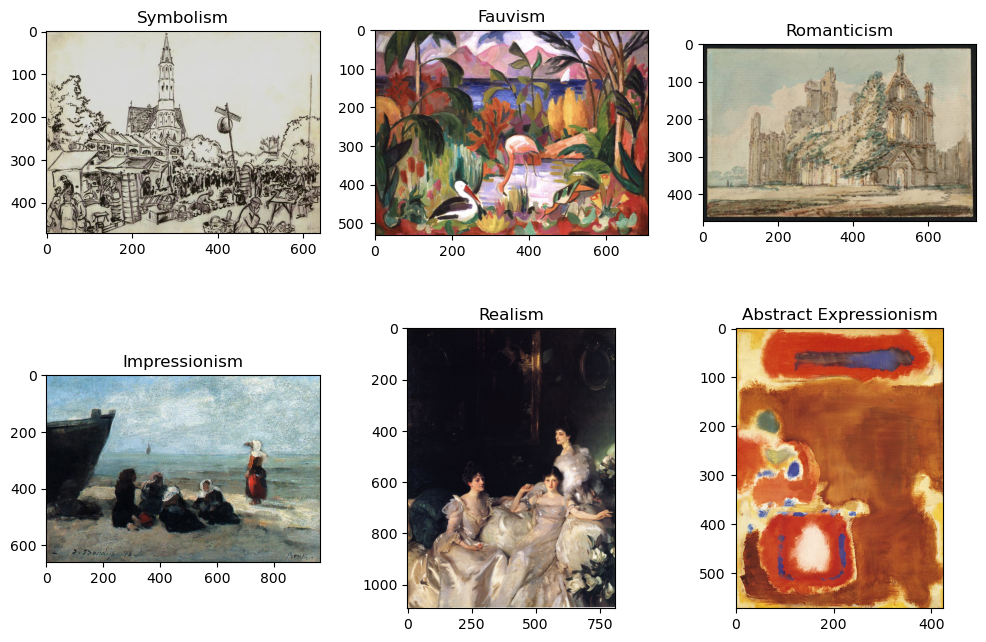

In [4]:
train_1_folder = "train_9"

# create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the first 6 images
for i in range(6):
    # get the image path and read the image
    img_name = os.listdir(train_1_folder)[i]
    img_path = os.path.join(train_1_folder, img_name)
    img = plt.imread(img_path)
    
    # find the corresponding row in the DataFrame
    row = df[df["new_filename"] == img_name].iloc[0]
    
    # get the artist, title, and style information
    artist = row["artist"]
    title = row["title"]
    style = row["style"]
    
    # plot the image in the appropriate subplot
    row_index, col_index = divmod(i, 3)
    axs[row_index, col_index].imshow(img)
    axs[row_index, col_index].set_title(style)

# show the figure
plt.show()

### Preprocessing

It is evident we have a ton of data to work with. Let's take a deeper look into the Style column since we will be working with it extensively.

In [5]:
df["style"].value_counts()

Impressionism               10643
Realism                     10523
Romanticism                  9285
Expressionism                7013
Post-Impressionism           5778
                            ...  
Spectralism                     5
Kinetic Art                     3
Ilkhanid                        2
Renaissance                     1
Environmental (Land) Art        1
Name: style, Length: 136, dtype: int64

There is a huge imbalance in the data here. We have 5 instances of artworks that fall under the spectralism category and have more than 10,000 impressionism style paintings. We would be naive to train our model on the dataset as is. We need to filter out styles that do not have enough samples and also those that have too many. Here, the choice for the threshold is really arbitrary and we decided to work with art styles with 2,000 samples. This means that styles like realism with several thousands of paintings need to be cut down to as close to 2,000 as possible.

Text(0.5, 0, 'Number of paintings')

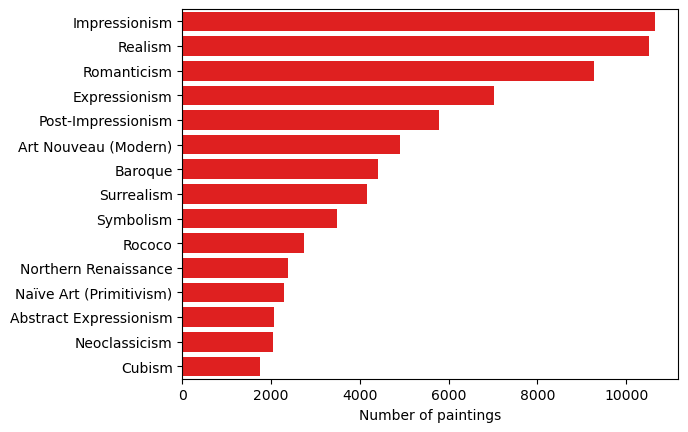

In [6]:
df["style"].value_counts()[:15]

sns.barplot(x=df["style"].value_counts()[:15].values, y=df["style"].value_counts()[:15].index,
            color="r")
plt.xlabel("Number of paintings")

Looking at the 15 most populated styles in our dataset, we see that Neoclassicism is just above our threshold with 2,038 samples. So, the next step is to cut down all samples above our threshold to meet our requirements for an unbiased dataset. To do this we will create a function to loop over the overpopulated styles, find the difference between them and the count for our Neoclassicism style, and reduce it to match our minimum limit.

In [7]:
overpop_styles = df["style"].value_counts()[:14].index.tolist()
overpop_styles

['Impressionism',
 'Realism',
 'Romanticism',
 'Expressionism',
 'Post-Impressionism',
 'Art Nouveau (Modern)',
 'Baroque',
 'Surrealism',
 'Symbolism',
 'Rococo',
 'Northern Renaissance',
 'Naïve Art (Primitivism)',
 'Abstract Expressionism',
 'Neoclassicism']

In [8]:
def style_balancer(style_arr, df):
    """
    Reduce the number of samples for each overpopulated style in the given DataFrame to match the count of the
    least represented style, and return a new DataFrame with the reduced number of samples for each style.

    Parameters:
        style_arr (list of str): A list of style names to balance.
        df (pandas.DataFrame): The DataFrame containing the samples to balance.

    Returns:
        pandas.DataFrame: A new DataFrame with the reduced number of samples for each style.

    Raises:
        None

    """

    # Get the minimum number of samples for any style in the DataFrame
    min_val = df["style"].value_counts()[13] # assuming "Neoclassicism" is at index 13

    # Initialize an empty DataFrame variable to hold the balanced samples for all styles
    empty_df_var = None

    # Loop through each style in the style_arr list
    for _style in style_arr:
        # Create a boolean mask to select only the samples with the current style
        style_mask = df["style"] == _style

        # Create a new DataFrame with only the samples with the current style
        style_df = df[style_mask]

        # Calculate the total number of samples for the current style
        tot = len(style_df.index)

        # Calculate the number of samples to remove to match the minimum count
        rmv = tot - min_val

        # Remove the excess samples from the current style DataFrame
        style_df.drop(style_df.index[range(rmv)], inplace=True)

        # Concatenate the current style DataFrame to the empty_df_var DataFrame to add it to the new DataFrame
        fin_df = pd.concat([empty_df_var, style_df], ignore_index=True)

        # Update the empty_df_var DataFrame with the new DataFrame containing the current style
        empty_df_var = fin_df

    # Return the final DataFrame containing the balanced samples for all styles
    return fin_df


df = style_balancer(overpop_styles, df)
df["style"].value_counts()


Impressionism              2038
Realism                    2038
Romanticism                2038
Expressionism              2038
Post-Impressionism         2038
Art Nouveau (Modern)       2038
Baroque                    2038
Surrealism                 2038
Symbolism                  2038
Rococo                     2038
Northern Renaissance       2038
Naïve Art (Primitivism)    2038
Abstract Expressionism     2038
Neoclassicism              2038
Name: style, dtype: int64

## TESTING SHI OUT

In [9]:
def style_returner(img_name):
    for i in range(len(df)):
        if img_name == df.loc[i, "new_filename"]:
            return df.loc[i, "style"]
        
style_returner('1165.jpg')

'Impressionism'

## SHUFFLE DATA

In [10]:
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

df["in_train"].value_counts()
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Arturo Souto,1962.0,portrait,643.0,800.0,172358.0,wikiart,Post-Impressionism,Bust of woman,train_only,True,89756.jpg
1,Peter Paul Rubens,1635,sketch and study,566.0,788.0,150833.0,wikiart,Baroque,Portrait of a Young Woman,train_and_test,True,80476.jpg
2,Gustave de Smet,1914.0,landscape,547.0,380.0,110714.0,wikiart,Impressionism,Haystacks,train_and_test,True,11721.jpg
3,Jacob van Strij,NaN,portrait,496.0,776.0,176290.0,wikiart,Neoclassicism,Standing countryman,train_only,True,40619.jpg
4,Gustave de Smet,1928.0,nude painting (nu),570.0,479.0,265082.0,wikiart,Expressionism,Nu couché,train_and_test,True,70790.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
28527,John William Waterhouse,NaN,religious painting,528.0,391.0,79503.0,wikiart,Romanticism,The Annunciation,train_and_test,False,42214.jpg
28528,David Roberts,NaN,genre painting,800.0,439.0,124084.0,wikiart,Romanticism,Ashdod,test_only,False,39535.jpg
28529,Vladimir Dimitrov,NaN,landscape,700.0,509.0,145152.0,wikiart,Post-Impressionism,unknown title,train_and_test,False,97371.jpg
28530,John Singleton Copley,1769,portrait,901.0,1119.0,138970.0,wikiart,Neoclassicism,Portrait of General Thomas Gage,train_and_test,True,83507.jpg


In [11]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(rescale=1./255)

# Create a flow_from_dataframe generator for the training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_1_folder,
    x_col='new_filename',
    y_col='style',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=train_1_folder,
    x_col='new_filename',
    y_col='style',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

Found 1796 validated image filenames belonging to 14 classes.


C:\Users\Lucas\anacond_fresh\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 21029 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


Found 468 validated image filenames belonging to 14 classes.


C:\Users\Lucas\anacond_fresh\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 5239 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


## Number of samples for each class in training set

In [12]:
class_indices = train_generator.class_indices
classes = train_generator.classes

newd = {key: 0 for key in class_indices}

for i in classes:
    for j, k in class_indices.items():
        if i == k:
            newd[j] += 1

newd

{'Abstract Expressionism': 115,
 'Art Nouveau (Modern)': 134,
 'Baroque': 146,
 'Expressionism': 130,
 'Impressionism': 143,
 'Naïve Art (Primitivism)': 124,
 'Neoclassicism': 126,
 'Northern Renaissance': 137,
 'Post-Impressionism': 128,
 'Realism': 117,
 'Rococo': 128,
 'Romanticism': 125,
 'Surrealism': 124,
 'Symbolism': 119}

## Number of samples for each class in testing set

In [13]:
class_indices = test_generator.class_indices
classes = test_generator.classes

newd = {key: 0 for key in class_indices}

for i in classes:
    for j, k in class_indices.items():
        if i == k:
            newd[j] += 1

newd

{'Abstract Expressionism': 36,
 'Art Nouveau (Modern)': 46,
 'Baroque': 32,
 'Expressionism': 36,
 'Impressionism': 30,
 'Naïve Art (Primitivism)': 37,
 'Neoclassicism': 24,
 'Northern Renaissance': 27,
 'Post-Impressionism': 31,
 'Realism': 35,
 'Rococo': 41,
 'Romanticism': 29,
 'Surrealism': 31,
 'Symbolism': 33}

In [14]:
data_augmentation = Sequential(
  [
    RandomFlip("horizontal",
                      input_shape=(256,
                                  256,
                                  3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

In [15]:
# define CNN model
model = Sequential(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)),
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(14, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)      

In [16]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

Epoch 1/10
57/57 [==============================] - 250s 4s/step - loss: 3.2679 - accuracy: 0.0791 - val_loss: 2.6323 - val_accuracy: 0.1090
Epoch 2/10
57/57 [==============================] - 250s 4s/step - loss: 2.6363 - accuracy: 0.0863 - val_loss: 2.6170 - val_accuracy: 0.0855
Epoch 3/10
57/57 [==============================] - 245s 4s/step - loss: 2.5997 - accuracy: 0.1075 - val_loss: 2.5589 - val_accuracy: 0.1389
Epoch 4/10
57/57 [==============================] - 206s 4s/step - loss: 2.5356 - accuracy: 0.1281 - val_loss: 2.4816 - val_accuracy: 0.1368
Epoch 5/10
57/57 [==============================] - 191s 3s/step - loss: 2.4756 - accuracy: 0.1487 - val_loss: 2.4887 - val_accuracy: 0.1538
Epoch 6/10
57/57 [==============================] - 186s 3s/step - loss: 2.4616 - accuracy: 0.1748 - val_loss: 2.5422 - val_accuracy: 0.1474
Epoch 7/10
57/57 [==============================] - 185s 3s/step - loss: 2.4345 - accuracy: 0.1726 - val_loss: 2.5703 - val_accuracy: 0.1517
Epoch 8/10
57

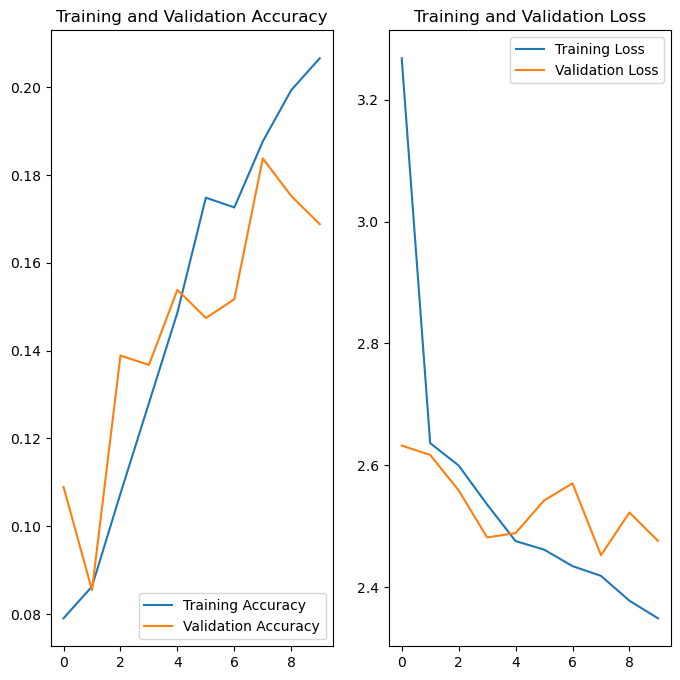

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

15/15 [==============================] - 16s 778ms/step


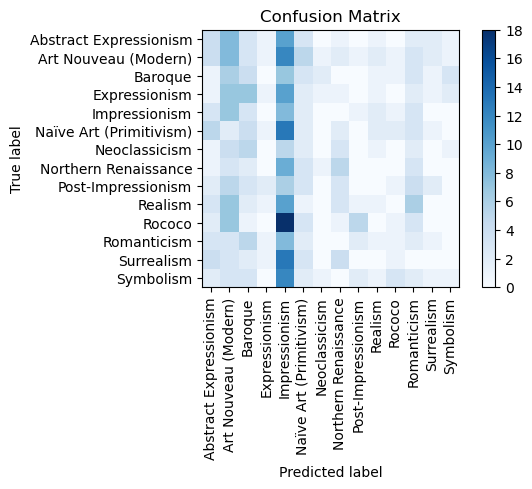

In [18]:
# Get the true labels and predicted labels for the test data
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Online model 

In [19]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(14, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 64, 64, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 64, 64, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 32, 32, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 32, 32, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 16, 16, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 18, 18, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 16, 16, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 16, 16, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 18, 18, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 8, 8, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 8, 8, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 8, 8, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 8, 8, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 8, 8, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

In [20]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))

# Print the accuracy
print("Accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
57/57 [==============================] - 211s 4s/step - loss: 2.6562 - accuracy: 0.1682 - val_loss: 2.2581 - val_accuracy: 0.2564
Epoch 2/10
57/57 [==============================] - 217s 4s/step - loss: 2.0481 - accuracy: 0.3291 - val_loss: 2.0531 - val_accuracy: 0.3632
Epoch 3/10
57/57 [==============================] - 207s 4s/step - loss: 1.7811 - accuracy: 0.4115 - val_loss: 1.9889 - val_accuracy: 0.3355
Epoch 4/10
57/57 [==============================] - 208s 4s/step - loss: 1.5378 - accuracy: 0.4850 - val_loss: 2.0109 - val_accuracy: 0.3355
Epoch 5/10
57/57 [==============================] - 209s 4s/step - loss: 1.2806 - accuracy: 0.5774 - val_loss: 1.9893 - val_accuracy: 0.3504
Epoch 6/10
57/57 [==============================] - 207s 4s/step - loss: 1.1359 - accuracy: 0.6236 - val_loss: 2.0194 - val_accuracy: 0.3419
Epoch 7/10
57/57 [==============================] - 217s 4s/step - loss: 0.9804 - accuracy: 0.6893 - val_loss: 1.9885 - val_accuracy: 0.3697
Epoch 8/10
57

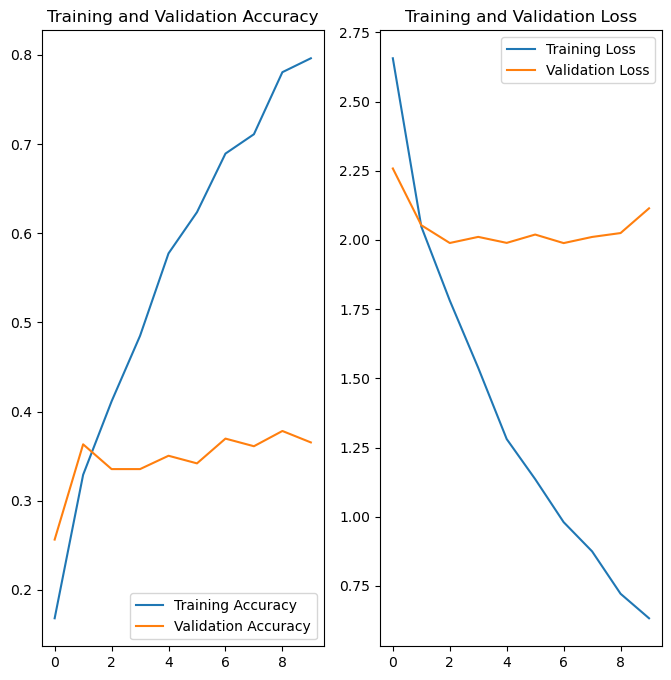

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

15/15 [==============================] - 59s 4s/step


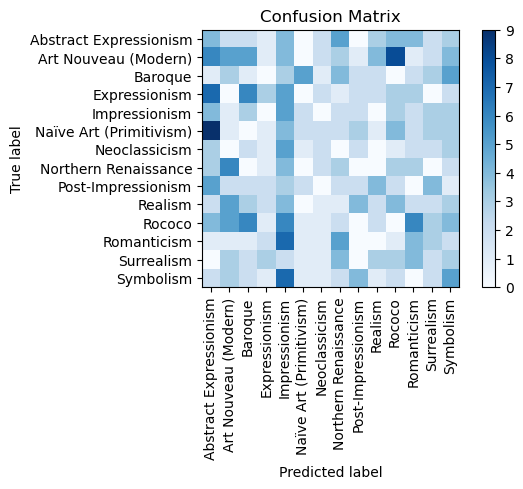

In [22]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()